# 实现基于梯度上升法的PCA

## 目录
* 基于梯度上升法的PCA原理
* 实现基于梯度上升法实现的PCA
* 用自制数据集验证手写的PCA

## 基于梯度上升法的PCA原理

PCA(Principal Component Analysis)：主成分分析  
可以用于数据降维，重新确定数据所在的空间的基，保留k个方差最大的基。  

故我们要找到令数据方差最大的基  
即寻找使样本空间上所有的点映射到这个轴后的方差最大$Var(x) = \frac{1}{m}\sum\limits_{i=1}^m(x_i-\bar x)^2$  

为了方便计算方差，我们会先对数据进行去均值(demean)处理，这样再计算投影点的方差时，无需再减去均值

故我们需要寻找一个轴的方向 w = (w1,w2,...,wn)
使得样本映射到w后，方差最大  
即$Var(X_{project}) = \frac{1}{m}\sum\limits_{i=1}^m||X_{project}^{(i)}||^2$  
若令w的膜为1  
则上式=$\frac{1}{m}\sum\limits_{i=1}^m||X^{(i)}\cdot w||^2$  

故这是一个最优化问题，寻找w，令Var最大  
可以采用梯度上升法，对w进行求解

-----
$\max\limits_{w} Var(X_{project}) = \frac{1}{m}\sum\limits_{i=1}^m||X^{(i)}\cdot w||^2$
对w求梯度

这个可以展开，方便进行求解  
上式为$\frac{1}{m}\sum\limits_{i=1}^m \big( \sum\limits_{j=1}^n X_j^{(i)}w_j\big)^2$  
对其中的$w_j$求导为
$\frac{2}{m}\sum\limits_{i=1}^m \Big((\sum\limits_{j=1}^n X_j^{(i)}w_j)X^{(i)}_j \Big)$

进行向量化后  
w的导数为$\frac{2}{m}X^T(Xw)$  
故通过梯度上升法，可以确定出第一个主成分

-------
求出第一个主成分以后，如何求出下一个主成分？

数据在第一个主成分上的分量上去掉在新数据上的第一主成分
再进行上述梯度上升法，找到w

----
高维数据如何映射为低维数据？  
$X_k = X W^T$

低维数据如何映射到高维数据？  
$X_m = X_k W $

## 实现基于梯度上升法实现的PCA

In [1]:
import numpy as np
class PCA_gradient():
    
    def __init__(self,n_component):
        self.n_component = n_component
        self.W = None #把基竖着写(和上述的原理不同之处)
    
    def fit(self,X):
        """获得数据集X的前n个主成分"""
        def demean(X):
            return X-X.mean(axis=0)
        
        def f(X,w):
            return np.sum(X.dot(w)**2)/len(X)
        
        def d_f(X,w):
            return X.T.dot(X.dot(w))*2/len(X)
        
        def debug_d_f(X,w,epsilon=1e-4):
            res = np.empty(len(w))
            for i in range(len(w)):
                w1 = w.copy()
                w1[i] += epsilon
                w2 = w.copy()
                w2[i] -= epsilon
                res[i] = (f(X,w1) - f(X,w2))/(2*epsilon)
            return res
        
        def direction(w):
            return w/np.linalg.norm(w)
        
        def find_first_component(df,X,inital_w,eta=0.01,itertion=int(1e4),E=1e-12):
            w = inital_w
            w = direction(w)
            for _ in range(itertion):
                w_old = w.copy()
                w += eta * df(X,w)
                w = direction(w)
                if abs(f(X,w) - f(X,w_old))<E:
                    break
            print(w)
            return w
        
        assert self.n_component <= X.shape[1],"the num of dimension reduction feature must be less"
        
        X = demean(X)
        self.W = np.empty((self.n_component,X.shape[1]))
        for i in range(self.n_component):
            inital_w = np.random.random(X.shape[1])
            self.W[i] = find_first_component(d_f,X,inital_w)
            X = X - (X.dot(self.W[i])).reshape(-1,1)*self.W[i]
        
        self.W = self.W.T
    
    def transform(self,X_new):
        return X_new.dot(self.W)
    
    def reversetransform(self,X_new):
        return X_new.dot(self.W.T) 

## 用自制数据集验证手写的PCA

In [2]:
import numpy as np
X = np.empty(shape=(100,2))
X[:,0] = np.random.uniform(0,100,size=100)
X[:,1] = X[:,0]*0.75 + 3 + np.random.normal(0,10,size=100)

In [3]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0],X[:,1])

In [4]:
pca = PCA_gradient(n_component=2)
pca.fit(X)

[0.77510722 0.63182972]
[ 0.63182975 -0.7751072 ]


In [5]:
pca.W

array([[ 0.77510722,  0.63182975],
       [ 0.63182972, -0.7751072 ]])

(0, 100)

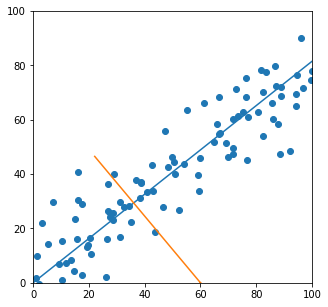

In [6]:
w1 = pca.W[:,0]
w2 = pca.W[:,1]
plt.figure(figsize=(5,5))
plt.scatter(X[:,0],X[:,1])
plt.plot([0,150*w1[0]],[0,150*w1[1]])
plt.plot([60,60*w2[0]+60,60-60*w2[0]],[0,60*w2[1],-60*w2[1]])
plt.xlim([0,100])
plt.ylim([0,100])

In [7]:
pca = PCA_gradient(n_component=1)
pca.fit(X)
X_k = pca.transform(X)
X_m = pca.reversetransform(X_k)

[0.77510722 0.63182972]


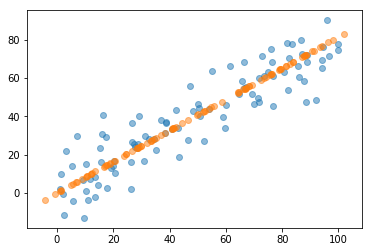

In [8]:
plt.scatter(X[:,0],X[:,1],alpha=0.5)
plt.scatter(X_m[:,0],X_m[:,1],alpha=0.5)

验证无误～